# Asset Management & Portfolio Optimization

This project was developed as part of the *Asset Management* course (2025) at NOVA SBE.  
It was completed collaboratively by **Group X: Marta Correia, Wael Zammit Chatti, and Nour Hadj Mtir**.  

The analysis explores fund performance and portfolio optimization using asset-pricing models,  
risk–return evaluation, and modern portfolio theory in Python.

# Preamble

In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats

In [41]:
# Let's use our functions that we defined earlier in the course

# Function to compute portfolio return from weights and asset returns
def portfolio_return(weights, returns):
    """
    - Computes the return on a portfolio from constituent returns and weights
    - Weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


# Function to compute portfolio standard deviation from weights and asset covariance matrix
def portfolio_vol(weights, covmat):
    """
    - Computes the vol of a portfolio from a covariance matrix and constituent weights
    - Weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5


# Function to compute the negative of the Sharpe ratio for a portfolio
def neg_sharpe(weights, riskfree_rate, er, cov):
    """
    Returns the negative of the Sharpe ratio
    of the given portfolio
    """
    r = portfolio_return(weights, er)
    vol = portfolio_vol(weights, cov)
    return -(r - riskfree_rate)/vol


# Function to compute the weights of the maximum Share ratio portfolio
# (minimizes the negative of the Sharpe ratio, using the "neg_sharpe" function)
def max_sr(riskfree_rate, er, cov, bounds):
    """
    Returns the weights of the portfolio that gives you the maximum Sharpe ratio
    given the riskfree rate, expected returns and the covariance matrix of returns
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


# Function to compute portfolio weights minimizing PF variance given constraints
# (you need to import the minimize function from scipy.optimize)
def minimize_vol(er, cov, bounds):
    """
    Returns the weights of the portfolio with the minimum variance
    for given weight bounds, a given set of expected returns
    and a covariance matrix.
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)

    # Construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


# Function to compute portfolio weights minimizing PF variance given constraints
# (additional constraint to minimize_vol function: achieve target return target_mu)
def minimize_vol_target_mu(er, cov, bounds, mu_target, init_guess):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]

    def er_equal_to_mu_target(weights):
        return weights.T @ er - mu_target

    # Construct the constraints
    constraints = [{'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1},   # weights sum to 1
                   {'type': 'eq',
                        'fun': er_equal_to_mu_target      # er equal to target
    }]

    weights = minimize(portfolio_vol, init_guess,
                       args=(cov), method='SLSQP',
                       options={'disp': False},
                       constraints=constraints,
                       bounds=bounds)
    return weights.x


# Trace out Capital Allocation Line
def CAL(rf, maxSR, x):
    return rf + maxSR*x


# Function to compute the weights of the minimum variance portfolio given a
# DataFrame with asset returns and weight bounds (the function then uses the
# minimize_vol function above)
def weight_gmv(r, bounds):
    er = r.mean()
    cov = r.cov()
    return minimize_vol(er, cov, bounds)


# Function to compute equal weights based on the number of input assets
def weight_ew(r):
    w = [ 1/len(r.columns) for x in range(len(r.columns))]
    w = np.array(w)
    return w


# Function to compute the drawdown
def drawdown(return_series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the price index,
       the high water mark, and
       the percentage drawdown
    """
    price_index = 1*(1+return_series).cumprod()
    high_water_mark = price_index.cummax()
    drawdowns = (high_water_mark - price_index)/high_water_mark
    return pd.DataFrame({"Price Index": price_index,
                         "High Water Mark": high_water_mark,
                         "Drawdown": drawdowns})


# Function to perform backtest on portfolio strategy given a weighting scheme
def backtest_ws(r, weighting, estimation_window=60, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of arguments
    """
    n_periods = r.shape[0]

    # List of overlapping rolling return windows for estimation
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]

    # List of portfolio weights over time
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]

    # Convert to DataFrame
    weights = pd.DataFrame(weights[:-1], index=r.iloc[estimation_window:].index, columns=r.columns) # make sure to
                # only use data up to time t-1 to estimate weights for month t
    returns = (weights * r).sum(axis="columns",  min_count=1) # mincount is to generate NAs if all inputs are NAs
    return returns, weights


# Function to run OLS regression defined by formula, input variables provided in
# DataFrame and named accordingly
def reg(formula, data):
    """
    - Run linear regression specified in formula (e.g., y ~ 1 + x)
    - Data (e.g., x and y) provided in DataFrame
    """
    model = sm.OLS.from_formula(formula, data=data)
    lm = model.fit()
    BHat = np.array(lm.params)
    StdB = np.sqrt(np.diag(lm.cov_params()))
    tstat = BHat/StdB    # lm.tvalues
    pval = 2*scipy.stats.norm.cdf(-abs(BHat/StdB)) # lm.pvalues

    return BHat, StdB, tstat, pval, lm







# Exercise 1

## Setup

In [44]:
# Load the data
r = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_gross_ret", header=0, index_col=0)/100
r.index = pd.to_datetime(r.index, format="%Y%m").to_period('M')
r=r.dropna()

f = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_TER", header=0, index_col=0)/100
f.index = pd.to_datetime(f.index, format="%Y%m").to_period('M')
f=f.dropna()

aum = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_AUM", header=0, index_col=0)/10**6
aum.index = pd.to_datetime(aum.index, format="%Y%m").to_period('M')
aum=aum.dropna()

cpi = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "cpi", header=0, index_col=0)
cpi.index = pd.to_datetime(cpi.index, format="%Y%m").to_period('M')
cpi=cpi.dropna()

rb = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "index_ret", header=0, index_col=0)/100
rb.index = pd.to_datetime(rb.index, format="%Y%m").to_period('M')
rb=rb.dropna()

ff = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "FF", header=0, index_col=0)/100
ff.index = pd.to_datetime(ff.index, format="%Y%m").to_period('M')
ff = ff.dropna()

In [45]:
# Rename the columns
rb = rb.rename(columns={'S&P 500 TR USD': 'SNP',
                        'Russell 2000 TR USD': 'R2',
                        'Russell 3000 Growth TR USD': 'R3G',
                        'Russell 3000 Value TR USD': 'R3V'})

ff = ff.rename(columns={'Mkt-RF': 'MktRf'})

In [46]:
rb.head()

,SNP,R2,R3G,R3V
Date,,,,
1990-01,-0.067136,-0.087366,-0.081984,-0.062885
1990-02,0.012881,0.031048,0.009189,0.025155
1990-03,0.026498,0.038895,0.040233,0.011715
1990-04,-0.024948,-0.032651,-0.014217,-0.038750
1990-05,0.097505,0.070780,0.102896,0.080810


## Question 1

### a)

In [49]:
# Compute net returns
net_ret = r - f

### Geometric mean function
def geometric_mean(returns):
    return np.prod(1 + returns) ** (1 / len(returns)) - 1

# Compute monthly arithmetic and geometric means for each fund (for both gross and net returns)
monthly_arith_gross = r.mean()
monthly_geo_gross = r.apply(geometric_mean)
monthly_arith_net = net_ret.mean()
monthly_geo_net = net_ret.apply(geometric_mean)

# Annualize the results:
# For arithmetic means: multiply by 12.
annual_arith_gross = monthly_arith_gross * 12
annual_arith_net = monthly_arith_net * 12

# For geometric means: compound the monthly geometric return over 12 periods.
annual_geo_gross = (1 + monthly_geo_gross) ** 12 - 1
annual_geo_net = (1 + monthly_geo_net) ** 12 - 1

# Combine the results into a summary DataFrame
performance_summary = pd.DataFrame({
    'Arithmetic Gross Return (annualized)': annual_arith_gross,
    'Geometric Gross Return (annualized)': annual_geo_gross,
    'Arithmetic Net Return (annualized)': annual_arith_net,
    'Geometric Net Return (annualized)': annual_geo_net
})



display(performance_summary.style.format("{:.2%}"))

,Arithmetic Gross Return (annualized),Geometric Gross Return (annualized),Arithmetic Net Return (annualized),Geometric Net Return (annualized)
Fund 1,11.89%,9.78%,10.46%,8.23%
Fund 2,9.73%,8.93%,8.83%,7.95%
Fund 3,9.78%,8.90%,9.53%,8.63%
Fund 4,10.96%,10.20%,9.61%,8.73%
Fund 5,10.05%,8.42%,8.34%,6.59%
Fund 6,8.08%,7.32%,6.94%,6.11%
Fund 7,14.59%,11.57%,13.53%,10.40%
Fund 8,12.05%,10.62%,11.13%,9.62%
Fund 9,10.52%,9.09%,10.17%,8.71%
Fund 10,12.19%,10.48%,10.33%,8.45%


### b)

In [51]:
# Align the time period with the market
market = rb.loc[r.index, "SNP"]

# Prepare dictionaries to hold results
capm_alphas_gross = {}
capm_betas = {}
capm_alphas_net = {}

for fund in r.columns:
    # Create a temporary DataFrame for the regression:
    df_temp = pd.DataFrame({
        'y': r[fund],      # Fund's gross monthly returns
        'Market': market   # S&P 500 returns
    })

    # Run the regression using our predefined function.
    BHat, StdB, tstat, pval, lm = reg("y ~ 1 + Market", data=df_temp)

    # Extract the monthly alpha (the intercept) and beta (coefficient on Market)
    monthly_alpha = BHat[0]
    beta = BHat[1]

    # Annualize the monthly alpha (multiply by 12)
    annual_alpha = monthly_alpha * 12
    capm_alphas_gross[fund] = annual_alpha
    capm_betas[fund] = beta

    # Compute average monthly fee for the fund and annualize it
    avg_fee_monthly = f[fund].mean()
    annual_fee = avg_fee_monthly * 12

    # Net alpha = annualized gross alpha minus annualized fee
    net_alpha = annual_alpha - annual_fee
    capm_alphas_net[fund] = net_alpha

# Compile the results into a summary DataFrame
capm_summary = pd.DataFrame({
    "CAPM Alpha (annual, gross)": pd.Series(capm_alphas_gross),
    "CAPM Alpha (annual, net)": pd.Series(capm_alphas_net),
    "Beta": pd.Series(capm_betas)
})

# Display the results
display(capm_summary.style.format("{:.2%}"))


,"CAPM Alpha (annual, gross)","CAPM Alpha (annual, net)",Beta
Fund 1,0.19%,-1.24%,120.24%
Fund 2,0.30%,-0.61%,96.92%
Fund 3,-0.12%,-0.37%,101.70%
Fund 4,1.71%,0.35%,95.05%
Fund 5,-1.46%,-3.17%,118.22%
Fund 6,-0.35%,-1.49%,86.58%
Fund 7,1.12%,0.05%,138.44%
Fund 8,1.72%,0.80%,106.12%
Fund 9,0.20%,-0.15%,106.02%
Fund 10,0.99%,-0.87%,115.06%


## c)

In [53]:
risk_measures = {}

# Align the risk-free rate with r index
rf = ff["RF"].loc[r.index]  # monthly risk-free rate (in decimal)

for fund in r.columns:
    # Get the monthly returns for the fund
    returns = r[fund]

    # Annualized standard deviation
    ann_vol = returns.std() * np.sqrt(12)

    # Skewness (monthly)
    skewness = returns.skew()

    # Kurtosis (monthly)
    kurt = returns.kurtosis()

    # Maximum Drawdown: using drawdown function
    dd_df = drawdown(returns)
    max_drawdown = dd_df["Drawdown"].max()

    # Sharpe Ratio:
    # Compute excess returns (each month) and then annualize the mean excess return
    excess = returns - rf
    ann_excess = excess.mean() * 12
    sharpe = ann_excess / ann_vol if ann_vol != 0 else np.nan

    risk_measures[fund] = {
        "Annualized Volatility": ann_vol,
        "Skewness": skewness,
        "Kurtosis": kurt,
        "Max Drawdown": max_drawdown,
        "Sharpe Ratio": sharpe}


# Convert the risk measures dictionary to a DataFrame
risk_df = pd.DataFrame(risk_measures).T


# Display the results
display(risk_df.style.format({
    "Annualized Volatility": "{:.2%}",
    "Max Drawdown": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Skewness": "{:.2f}",
    "Kurtosis": "{:.2f}"}))

,Annualized Volatility,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio
Fund 1,22.38%,-0.36,0.50,54.59%,0.45
Fund 2,15.12%,-0.50,1.20,51.96%,0.52
Fund 3,15.58%,-0.50,0.87,51.15%,0.51
Fund 4,15.47%,-0.60,1.66,49.65%,0.59
Fund 5,19.61%,-0.38,1.13,67.97%,0.42
Fund 6,14.07%,-0.49,0.92,49.92%,0.44
Fund 7,26.48%,-0.48,2.69,80.41%,0.48
Fund 8,19.51%,-0.36,1.71,61.46%,0.52
Fund 9,18.77%,-0.58,1.40,52.60%,0.46
Fund 10,20.75%,-0.55,1.49,62.61%,0.50


## Question 2

### a)

In [56]:
# Align ff's data to r and f by taking only the rows that match r.index:
r_2 = r.copy()
f_2 = f.copy()
ff_2 = ff.loc[r.index]

# Prepare dictionaries to hold the results for each fund
ff5_alphas_gross = {}  # Annualized FF5 gross alphas
ff5_alphas_net = {}    # Annualized FF5 net alphas
ff5_betas = {}         # Factor betas for each fund (for question 2.b)

for fund in r_2.columns:
    # Create a temporary DataFrame for the regression
    df_temp = pd.DataFrame({
        'y': r_2[fund] - ff_2["RF"],  # Fund's monthly excess return
        'MktRf': ff_2["MktRf"],
        'SMB': ff_2["SMB"],
        'HML': ff_2["HML"],
        'RMW': ff_2["RMW"],
        'CMA': ff_2["CMA"]
    })

    # Run the regression using our predefined function "reg"
    BHat, StdB, tstat, pval, lm = reg("y ~ 1 + MktRf + SMB + HML + RMW + CMA", data=df_temp)

    # Extract the monthly alpha (the constant) and then annualize it:
    monthly_alpha = BHat[0]
    annual_alpha = monthly_alpha * 12
    ff5_alphas_gross[fund] = annual_alpha

    # Compute the annualized fee for the fund:
    avg_fee_monthly = f_2[fund].mean()  # Average monthly fee
    annual_fee = avg_fee_monthly * 12

    # Net alpha = gross alpha (annual) minus annualized fee:
    ff5_alphas_net[fund] = annual_alpha - annual_fee

    # Save the factor betas
    ff5_betas[fund] = BHat[1:]

# Compile the alphas into a summary DataFrame
ff5_summary = pd.DataFrame({
    "FF5 Alpha (annual, gross)": pd.Series(ff5_alphas_gross),
    "FF5 Alpha (annual, net)": pd.Series(ff5_alphas_net)
})

# Display the results
display(ff5_summary.style.format("{:.2%}"))


,"FF5 Alpha (annual, gross)","FF5 Alpha (annual, net)"
Fund 1,0.37%,-1.06%
Fund 2,-0.36%,-1.27%
Fund 3,-0.60%,-0.85%
Fund 4,-0.23%,-1.58%
Fund 5,-0.14%,-1.85%
Fund 6,-1.31%,-2.45%
Fund 7,6.43%,5.36%
Fund 8,2.87%,1.96%
Fund 9,-0.70%,-1.06%
Fund 10,1.83%,-0.03%


### b)

In [58]:
# Convert the factor betas dictionary to a DataFrame
ff5_betas_df = pd.DataFrame(ff5_betas).T

# Display the betas:
display(ff5_betas_df.style.format("{:.2f}"))

# Fund 7's factor betas:
fund7_betas = ff5_betas_df.loc["Fund 7"]
print("Factor Betas for Fund 7:")
print(fund7_betas)

,0,1,2,3,4
Fund 1,1.07,0.67,-0.16,-0.05,-0.22
Fund 2,0.97,-0.09,0.03,0.10,0.00
Fund 3,1.02,-0.13,0.03,0.09,0.01
Fund 4,0.96,0.13,0.10,0.16,0.17
Fund 5,1.13,-0.10,0.37,-0.18,-0.07
Fund 6,0.88,-0.10,0.20,0.05,0.10
Fund 7,1.21,-0.08,-0.38,-0.61,-0.30
Fund 8,1.00,-0.10,0.80,-0.16,-0.21
Fund 9,0.97,0.58,0.03,0.03,-0.09
Fund 10,1.06,0.29,-0.21,-0.14,-0.08


Factor Betas for Fund 7:
0    1.211862
1   -0.076721
2   -0.381371
3   -0.605587
4   -0.301607
Name: Fund 7, dtype: float64


Fund 7 looks to invest in large-cap growth firms with low present profitability but strong potential for future growth.  These stocks are probably high-risk, high-reward investments that rely on future earnings rather than solid current cash flows.  This fund's high market beta (1.21) makes it more susceptible to market fluctuations, which means it may outperform in bull markets but suffer bigger drawdowns in down markets.This profile shows that Fund 7 may pursue an aggressive growth strategy, potentially preferring sectors such as technology, innovation-driven enterprises, or industry disruptors.


### c)

A) Secular Growth + Innovative Companies (AI)

    Best Match → Fund 1 (Small-Growth)
        SMB = 0.67 (Small-cap bias)
        HML = -0.16 (Growth tilt)
        Strategy A mentions "accelerating revenue growth" and a focus on smaller emerging firms—which aligns with Fund 1's strong small-growth exposure.

(B) Small-cap Value + Dividend Stocks

    Best Match → Fund 8 (Strongest Value Tilt)
        SMB = -0.10 (Not very small, but smaller than large-cap peers)
        HML = 0.80 (Very strong value)
        Strategy B mentions "tilted towards value," "high dividend stocks," and a small-cap focus. Fund 8’s strong value orientation makes it the best fit.

(C) Mid/Small-Cap + Balanced Growth

    Best Match → Fund 4 (Moderate Size + Balanced Growth/Value)
        SMB = 0.13 (Slightly smaller than large peers)
        HML = 0.10 (Mild value tilt)
        Strategy C describes "stocks ranging from $100M up to large Russell 2000 constituents," meaning mid/small-cap but not extreme small-cap—which fits Fund 4.

(D) Large-Cap Growth + Low Volatility

    Best Match → Fund 7 (Strongest Large-Growth Fund)
        SMB = -0.08 (Large-cap tilt)
        HML = -0.38 (Very strong growth tilt)
        Strategy D mentions "exposure to the Growth factor," "large-cap orientation," and "low volatility stocks." Fund 7 fits this description.

(E) S&P 500 Enhanced Index

    Best Match → Fund 2 (Near-Market Beta)
        MktRf = 0.97 (Near 1, tracks S&P 500)
        Minimal SMB, HML, RMW, CMA effects
      "trades more frequently than the average peer in its category, which may result in higher trading costs for investors and cause a drag on performance"
      So, it should not have strong tilts toward small-cap, value, or growth stocks.
      Strategy E describes an S&P 500 plus strategy—Fund 2 matches best.

## Question 3

### a)

In [64]:
# Align CPZ data with r and f
cpz_factors = pd.DataFrame({
    'SNP': rb.loc[r.index, 'SNP'],                  # Market (S&P 500)
    'SMB_CPZ': rb.loc[r.index, 'R2'] - rb.loc[r.index, 'SNP'],   # Russell 2000 - S&P 500
    'HML_CPZ': rb.loc[r.index, 'R3V'] - rb.loc[r.index, 'R3G'],  # Russell 3000 Value - Growth
    'MOM': ff.loc[r.index, 'MOM']                    # Momentum
})

# Prepare dictionaries to hold results
cpz_alphas_gross = {}
cpz_alphas_net = {}

for fund in r.columns:
    # Fund's monthly excess returns (gross)
    Y = r[fund]

    # CPZ design matrix (with constant added for alpha)
    X = cpz_factors
    X = sm.add_constant(X)

    # Run the regression
    model = sm.OLS(Y, X).fit()

    # Save the factor betas (excluding the constant) for later use for the abnormal returns
    ff5_betas[fund] = model.params[1:]

    # Extract the monthly alpha (constant) and annualize it
    monthly_alpha = model.params["const"]
    annual_alpha = monthly_alpha * 12
    cpz_alphas_gross[fund] = annual_alpha

    # Annualized net alpha = gross alpha - annualized fee
    avg_fee_monthly = f[fund].mean()  # Average monthly fee
    annual_fee = avg_fee_monthly * 12
    cpz_alphas_net[fund] = annual_alpha - annual_fee

# Compile the results into a DataFrame
cpz_summary = pd.DataFrame({
    "CPZ Alpha (annual, gross)": pd.Series(cpz_alphas_gross),
    "CPZ Alpha (annual, net)": pd.Series(cpz_alphas_net)})

# Display results
display(cpz_summary.style.format("{:.2%}"))


,"CPZ Alpha (annual, gross)","CPZ Alpha (annual, net)"
Fund 1,0.15%,-1.28%
Fund 2,0.21%,-0.70%
Fund 3,-0.11%,-0.36%
Fund 4,2.00%,0.65%
Fund 5,-0.57%,-2.28%
Fund 6,-0.51%,-1.64%
Fund 7,2.13%,1.06%
Fund 8,2.17%,1.26%
Fund 9,0.32%,-0.03%
Fund 10,0.40%,-1.47%


###b)

When measuring performance, an index-based benchmark model outperforms the Fama-French factor model in various ways:
1. Investability and Transparency: Index-based benchmarks, such as the S&P 500 and Russell indexes, are made up of investable securities that investors can easily follow and understand.  This makes them more visible and easier to duplicate than factor portfolios built with statistical models.

2. Benchmarks based on well-known indexes offer simplicity and clarity.  Investors may easily compare a fund's performance to a well-known market index rather than interpreting abstract factor loadings, which may be difficult to understand.

3. Market indices are commonly used by investors and institutions for benchmarking purposes.  Using an index-based benchmark aligns performance evaluation with real-world investment decisions and expectations, as opposed to theoretically determined criteria.
4. Reduced Model Risk: Factor models require accurate factor estimate and may be affected by sample selection and data changes.  An index-based benchmark eliminates the possible estimate mistakes and model specification difficulties associated with factor models.

5. According to Cremers, Petajisto, and Zitzewitz (2012), prominent passive indexes frequently outperform Fama-French factor models.  Using an index-based benchmark, performance evaluation focuses on how a manager offers value relative to an investable, tangible alternative rather than exclusively on model-based risk decompositions.

In conclusion, index-based benchmarks are frequently selected because they are simpler, more straightforward, and directly investable, and they can give a more accurate comparison for performance evaluation than multi-factor models, which may be overparameterized or less representative of actual market indexes.


In [67]:
# Compute and store the abnormal returns time series for each fund
abnormal_returns = {}

for fund in r.columns:
    # Retrieve the estimated CPZ betas for the fund (a Series with indices "SNP", "SMB_CPZ", "HML_CPZ", "MOM")
    betas = ff5_betas[fund]

    # Compute the benchmark predicted excess return at each time t.
    # For each factor k, we subtract the risk-free rate from the factor return.
    predicted_excess = (
      (cpz_factors["SNP"] - rf) * betas["SNP"] +
      cpz_factors["SMB_CPZ"] * betas["SMB_CPZ"] +
      cpz_factors["HML_CPZ"] * betas["HML_CPZ"] +
      cpz_factors["MOM"] * betas["MOM"])

    # Abnormal return time series for the fund:
    # Fund's excess return minus the benchmark's predicted excess return.
    abnormal = r[fund] - rf - predicted_excess

    # Save the abnormal returns time series in the dictionary.
    abnormal_returns[fund] = abnormal

# Now 'abnormal_returns' is a dictionary where each key is a fund name and each value is a pandas Series
# containing the time series of abnormal returns for that fund.

# Optionally, you can convert the dictionary into a DataFrame for easier inspection:
abnormal_returns_df = pd.DataFrame(abnormal_returns)

# Display the first few rows of the abnormal returns DataFrame:
display(abnormal_returns_df.head())


,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10
Date,,,,,,,,,,
1998-10,-0.007389,-0.012998,0.000376,0.000535,0.031519,-0.023576,-0.080389,0.017288,0.005663,-0.001390
1998-11,-0.040968,0.008675,-0.004109,0.007679,0.014890,-0.020207,0.004620,0.020611,0.017819,-0.003839
1998-12,0.009647,0.020991,0.006866,0.008815,0.084074,-0.040443,0.016781,0.009176,-0.021597,0.035379
1999-01,-0.029330,-0.015672,-0.005660,0.007424,0.062286,-0.014274,0.026246,-0.009929,-0.015440,-0.051020
1999-02,-0.002220,-0.003198,-0.000982,0.029402,0.020782,-0.012934,-0.014028,0.017442,0.007217,0.043131


## Question 4



### a)

#### Step 1. Adjust AUM for Inflation

In [71]:
cpi_series = cpi.iloc[:, 0]

# Get the CPI for December 2024
cpi_dec2024 = cpi_series.loc['2024-12']

# Adjust AUM to December 2024 dollars:
aum_cpi_adj = aum.div(cpi_series, axis=0) * cpi_dec2024


#### Step 2. Compute Abnormal Returns Time Series

In [73]:
# We'll create a new dictionary to store net abnormal returns
net_abnormal_returns = {}

for fund in r.columns:
    # Use the abnormal returns from Q 3.b
    abnormal = abnormal_returns[fund]

    # Subtract the monthly fee from the abnormal return
    net_abnormal = abnormal - f[fund]

    # Store the result
    net_abnormal_returns[fund] = net_abnormal

#### Step 3. Compute Value Added Measures

In [75]:
# Lag the CPI-adjusted AUM by one month
lagged_aum = aum_cpi_adj.shift(1)

# Dictionaries to hold value added measures
value_added = {}      # Gross Value Added
net_value_added = {}  # Net Value Added

for fund in r.columns:
    # Multiply abnormal returns by lagged AUM to get Value Added
    VA_series = abnormal_returns[fund] * lagged_aum[fund]
    net_VA_series = net_abnormal_returns[fund] * lagged_aum[fund]

    # Compute the sample average
    value_added[fund] = VA_series.mean()
    net_value_added[fund] = net_VA_series.mean()

#### Step 4. Compute Average CPI-Adjusted AUM

In [77]:
avg_aum = aum_cpi_adj.mean()

#### Step 5. Compile and Report the Results

In [79]:
# Compile Value Added measures into a DataFrame
VA_summary = pd.DataFrame({
    "Gross Value Added": pd.Series(value_added),
    "Net Value Added": pd.Series(net_value_added),
    "Avg CPI-Adjusted AUM (millions USD)": pd.Series(avg_aum)})

# include the CPZ alphas from question 3:
combined_summary = cpz_summary.join(VA_summary)

# Display the combined summary
display(combined_summary.style.format({
    "Gross Value Added": "{:.2f}",
    "Net Value Added": "{:.2f}",
    "Avg CPI-Adjusted AUM (millions USD)": "${:,.2f}",
    "CPZ Alpha (annual, gross)": "{:.2%}",
    "CPZ Alpha (annual, net)": "{:.2%}"}))

,"CPZ Alpha (annual, gross)","CPZ Alpha (annual, net)",Gross Value Added,Net Value Added,Avg CPI-Adjusted AUM (millions USD)
Fund 1,0.15%,-1.28%,-4.57,-6.68,"$1,981.72"
Fund 2,0.21%,-0.70%,2.07,-9.07,"$14,915.53"
Fund 3,-0.11%,-0.36%,-0.07,-0.13,$308.59
Fund 4,2.00%,0.65%,5.60,1.85,"$3,312.63"
Fund 5,-0.57%,-2.28%,-8.96,-24.48,"$11,014.27"
Fund 6,-0.51%,-1.64%,-1.59,-2.62,"$1,118.55"
Fund 7,2.13%,1.06%,-1.22,-1.77,$695.11
Fund 8,2.17%,1.26%,1.40,0.82,$784.86
Fund 9,0.32%,-0.03%,-0.31,-0.56,$847.78
Fund 10,0.40%,-1.47%,1.00,0.12,$545.91


### b)


To assess whether fund managers are skillful, we rely on CPZ Alpha (annual, net), which indicates the risk-adjusted excess return after fees:

* A smart manager should have a positive net alpha, which means they create returns that exceed the CPZ benchmark even after costs.
* In the table, all funds had negative net alphas, indicating that no fund consistently beat the CPZ benchmark after costs.
* Most Skilled Manager?
 Fund 8 has the greatest net alpha (1.26%), which means it outperformed its rivals despite being slightly negative.


### c)


To evaluate the fund that produced the highest value in absolute financial terms, we focus on Net Value Added (measured in millions of US dollars).

* Fund 4 has the highest Net Value Added ($1.85 million), indicating that it provided the biggest surplus profits in dollar terms to investors after costs.
* Even though Fund 8 had the highest net alpha, Fund 4's greater AUM allowed it to earn a better total dollar return for investors.



# Exercise 2

In [85]:
# Load the data
r = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_gross_ret", header=0, index_col=0)/100
r.index = pd.to_datetime(r.index, format="%Y%m").to_period('M')

f = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "funds_TER", header=0, index_col=0)/100
f.index = pd.to_datetime(f.index, format="%Y%m").to_period('M')

ff = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "FF", header=0, index_col=0)/100
ff.index = pd.to_datetime(ff.index, format="%Y%m").to_period('M')

vanret = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "vanguard_net", header=0, index_col=0)/100
vanret.index = pd.to_datetime(vanret.index, format="%Y%m").to_period('M')

In [86]:
# Rename the columns
vanret = vanret.rename(columns={'Vanguard 500 Index': 'V500',
                        'Vanguard Extended Market Index': 'VExM',
                        'Vanguard Small Cap Index': 'VSC',
                        'Vanguard European Stock Index': 'VES',
                        'Vanguard Pacific Stock Index': 'VPC',
                        'Vanguard Value Index': 'VV',
                        'Vanguard Balanced Index': 'VB',
                        'Vanguard Emerging Mkts Stock Idx': 'VEMS',
                        'Vanguard Mid Cap Index': 'VMC',
                        'Vanguard Small Cap Growth Index': 'VSCG',
                        'Vanguard Small Cap Value Index': 'VSCV'})
ff = ff.rename(columns={'Mkt-RF': 'MktRf'})

## Question 1

###a)

In [89]:

#rf
rf_estimate = ff["RF"].mean()

# Expected (arithmetic) returns
expected_returns = vanret.mean() * 12

# Expected excess returns
expected_excess_returns = expected_returns - rf_estimate

# Variance-covariance matrix
cov_matrix = vanret.cov() * 12

# Standard deviations (volatility)
std_devs = np.sqrt(np.diag(cov_matrix))

#  Sharpe Ratios
sharpe_ratios = expected_excess_returns / std_devs


summary_stats = pd.DataFrame({
    'Expected Return (µ)': expected_returns,
    'Expected Excess Return (µe)': expected_excess_returns,
    'Standard Deviation (σ)': std_devs,
    'Sharpe Ratio': sharpe_ratios
})


display(summary_stats.style.format("{:.2%}"))

,Expected Return (µ),Expected Excess Return (µe),Standard Deviation (σ),Sharpe Ratio
V500,11.11%,10.89%,14.83%,73.43%
VExM,11.42%,11.20%,19.04%,58.81%
VSC,11.56%,11.34%,19.12%,59.30%
VES,8.04%,7.83%,17.61%,44.44%
VPC,4.48%,4.26%,18.21%,23.40%
VV,10.47%,10.25%,14.92%,68.71%
VB,8.38%,8.16%,9.51%,85.78%
VEMS,7.81%,7.59%,21.84%,34.76%
VMC,11.16%,10.94%,17.97%,60.92%
VSCG,10.76%,10.54%,20.88%,50.49%


###b)

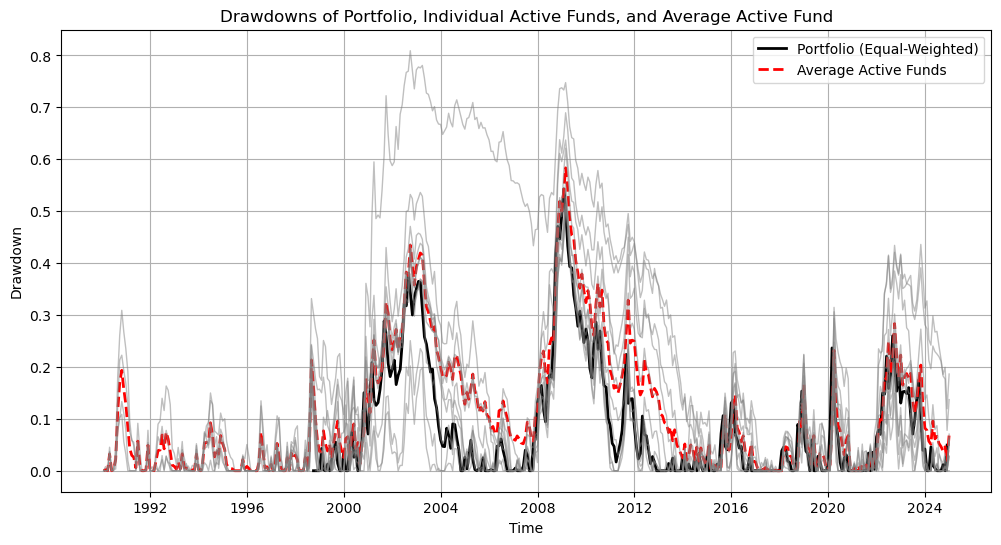

In [91]:
# Drawdown function
def drawdown(return_series):
    price_index = (1 + return_series).cumprod()
    high_water_mark = price_index.cummax()
    drawdowns = (high_water_mark- price_index ) / high_water_mark
    return drawdowns

active_net_ret = r - f

# Active and passive funds
all_funds = pd.concat([active_net_ret, vanret], axis=1).dropna()


if isinstance(all_funds.index, pd.PeriodIndex):
    all_funds.index = all_funds.index.to_timestamp()
else:
    try:
        all_funds.index = pd.to_datetime(all_funds.index)
    except:
        print("Index could not be converted to datetime. Check the format.")
        raise

# Equal-weighted portfolio return
equal_weights = np.ones(all_funds.shape[1]) / all_funds.shape[1]
portfolio_ret = all_funds @ equal_weights

# Drawdowns computation
portfolio_drawdown = drawdown(portfolio_ret)
active_drawdowns = active_net_ret.apply(drawdown)
average_active_drawdown = active_drawdowns.mean(axis=1)


plt.figure(figsize=(12, 6))
plt.plot(portfolio_drawdown.index, portfolio_drawdown.values, label="Portfolio (Equal-Weighted)", linewidth=2, color="black")
plt.plot(average_active_drawdown.index, average_active_drawdown.values, label="Average Active Funds", linewidth=2, color="red", linestyle="--")


for fund in active_drawdowns.columns:
    plt.plot(active_drawdowns.index, active_drawdowns[fund], color="gray", alpha=0.5, linewidth=1)

plt.title("Drawdowns of Portfolio, Individual Active Funds, and Average Active Fund")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.legend()
plt.grid()
plt.show()

###c)

In [93]:

# Expected annualized returns for all funds
mu = all_funds.mean() * 12

# Expected excess returns
mu_excess = mu - rf_estimate

# Annualized variance-covariance matrix
cov_matrix = all_funds.cov() * 12

# Maximum Sharpe ratio analytically
max_sharpe_ratio_analytical = np.sqrt(mu_excess.T @ np.linalg.inv(cov_matrix) @ mu_excess)


print(f"Maximum Sharpe Ratio (Analytical): {max_sharpe_ratio_analytical:.4f}")


Maximum Sharpe Ratio (Analytical): 1.8265


##Question 2

###a)

In [96]:
all_funds.head()

,Fund 1,Fund 2,Fund 3,Fund 4,Fund 5,Fund 6,Fund 7,Fund 8,Fund 9,Fund 10,...,VExM,VSC,VES,VPC,VV,VB,VEMS,VMC,VSCG,VSCV
Date,,,,,,,,,,,,,,,,,,,,,
1998-10-01,0.040921,0.062878,0.082629,0.067619,0.119039,0.045643,0.005995,0.097726,0.054754,0.057854,...,0.058519,0.042111,0.078261,0.176000,0.078708,0.042489,0.154294,0.089728,0.048593,0.043928
1998-11-01,0.026786,0.066349,0.057059,0.055236,0.074260,0.025853,0.099800,0.065504,0.072832,0.067647,...,0.062631,0.053067,0.053905,0.047619,0.052385,0.039610,0.063052,0.050921,0.071951,0.043317
1998-12-01,0.098048,0.077100,0.064991,0.049352,0.130583,-0.001200,0.129460,0.035020,0.042611,0.127650,...,0.085842,0.062317,0.042117,0.026755,0.035016,0.039599,-0.030686,0.123549,0.087734,0.043498
1999-01-01,0.008814,0.022819,0.036402,0.027379,0.090743,0.008298,0.112874,-0.004165,0.007620,-0.001375,...,0.014691,0.012264,-0.007516,0.006378,0.019991,0.024892,-0.029077,-0.038925,-0.012592,-0.011442
1999-02-01,-0.092911,-0.035793,-0.033016,-0.005494,-0.021320,-0.035381,-0.103106,-0.008963,-0.061185,-0.031732,...,-0.054698,-0.081081,-0.026704,-0.020279,-0.021777,-0.029039,0.022135,-0.052073,-0.097768,-0.081019


Tangency Portfolio

In [98]:

active_funds = r.columns.tolist()
net_returns = r - f.loc[r.index, active_funds]

# Active and passive funds
returns = pd.concat([net_returns, vanret], axis=1, join='inner')


# Separate active and passive assets
active_assets = net_returns.columns.tolist()
passive_assets = vanret.columns.tolist()


# Mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Risk-free rate
risk_free_rate = ff['RF'].mean()

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Constraints
def constraint_functions(active_assets, passive_assets):

    num_active = len(active_assets)
    num_passive = len(passive_assets)

    # Constraint 1: No short sales for active funds, max 10%
    active_bounds = [(0, 0.1)] * num_active

    # Constraint 2: Short sales restricted to 5% for passive funds, max 100%
    passive_bounds = [(-0.05, 1)] * num_passive

    # Combine bounds for all assets
    bounds = active_bounds + passive_bounds

    # Constraint 3: Total weight in passive indices >= 50%
    def passive_constraint(weights):
        return np.sum(weights[num_active:]) - 0.5  # >= 0

    # Constraint 4: Combined weight in active indices >= 25%
    def active_constraint(weights):
        return np.sum(weights[:num_active]) - 0.25 # >=0

    # Constraint 5: Sum of all weights must equal 1
    def sum_weights_constraint(weights):
        return np.sum(weights) - 1  # == 0

    # Constraints dictionary
    constraints = (
        {'type': 'eq', 'fun': sum_weights_constraint},  # Sum of weights = 1
        {'type': 'ineq', 'fun': passive_constraint},  # Passive >= 50%
        {'type': 'ineq', 'fun': active_constraint}  # Active >= 25%
    )

    return bounds, constraints



def optimize_tangency_portfolio(mean_returns, cov_matrix, risk_free_rate, active_assets, passive_assets):


    num_assets = len(mean_returns)
    initial_weights = np.array([1/num_assets] * num_assets)

    bounds, constraints = constraint_functions(active_assets, passive_assets)


    # Optimization
    result = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print("Tangency Portfolio Optimization Failed:", result.message)
        return None




def optimize_min_variance_portfolio(cov_matrix, active_assets, passive_assets):
    """
    Calculates the minimum variance portfolio weights using numerical optimization with constraints.

    Args:
        cov_matrix (pd.DataFrame): Covariance matrix of all assets.
        active_assets (list): List of active asset names.
        passive_assets (list): List of passive asset names.

    Returns:
        np.ndarray: Optimal weights for the minimum variance portfolio.
    """

    num_assets = len(cov_matrix)
    initial_weights = np.array([1/num_assets] * num_assets)  # Initial guess


    bounds, constraints = constraint_functions(active_assets, passive_assets)


    # Optimization
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print("Minimum Variance Portfolio Optimization Failed:", result.message)
        return None



tangency_weights = optimize_tangency_portfolio(mean_returns, cov_matrix, risk_free_rate, active_assets, passive_assets)


if tangency_weights is not None:
    print("Tangency Portfolio Weights:")
    for i, asset in enumerate(returns.columns):
        print(f"{asset}: {tangency_weights[i]:.4f}")





Tangency Portfolio Weights:
Fund 1: 0.0000
Fund 2: 0.1000
Fund 3: 0.0000
Fund 4: 0.1000
Fund 5: 0.0000
Fund 6: 0.0000
Fund 7: 0.0000
Fund 8: 0.0288
Fund 9: 0.0000
Fund 10: 0.0212
V500: 0.1216
VExM: -0.0500
VSC: -0.0031
VES: -0.0500
VPC: -0.0500
VV: -0.0184
VB: 1.0000
VEMS: -0.0500
VMC: -0.0500
VSCG: -0.0500
VSCV: -0.0500


Minimum Variance Portfolio

In [100]:

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))


def optimize_min_variance_portfolio(cov_matrix, active_assets, passive_assets):


    num_assets = len(cov_matrix)
    initial_weights = np.array([1/num_assets] * num_assets)


    bounds, constraints = constraint_functions(active_assets, passive_assets)


    # Optimization
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print("Minimum Variance Portfolio Optimization Failed:", result.message)

        return None

min_variance_weights = optimize_min_variance_portfolio(cov_matrix, active_assets, passive_assets)

if min_variance_weights is not None:
    print("\nMinimum Variance Portfolio Weights:")
    for i, asset in enumerate(returns.columns):
        print(f"{asset}: {min_variance_weights[i]:.4f}")






Minimum Variance Portfolio Weights:
Fund 1: 0.0000
Fund 2: 0.0526
Fund 3: 0.0000
Fund 4: 0.1000
Fund 5: 0.0002
Fund 6: 0.0967
Fund 7: 0.0000
Fund 8: 0.0000
Fund 9: 0.0004
Fund 10: 0.0000
V500: -0.0038
VExM: -0.0500
VSC: -0.0500
VES: -0.0500
VPC: 0.0749
VV: 0.0288
VB: 1.0000
VEMS: -0.0500
VMC: -0.0500
VSCG: -0.0500
VSCV: -0.0500


Efficient Frontier

C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Efficient Frontier Optimization Failed for target return 0.010828990385252087: Iteration limit reached
Efficient Frontier Optimization Failed for target return 0.010993984027511068: Positive directional derivative for linesearch
Efficient Frontier Optimization Failed for target return 0.011158977669770049: Positive directional derivative for linesearch
Efficient Frontier Optimization Failed for target return 0.011323971312029028: Iteration limit reached
Efficient Frontier Optimization Failed for target return 0.011488964954288007: Positive directional derivative for linesearch
Efficient Frontier Optimization Failed for target return 0.011653958596546988: Positive directional derivative for linesearch
Efficient Frontier Optimization Failed for target return 0.011818952238805969: Positive directional derivative for linesearch


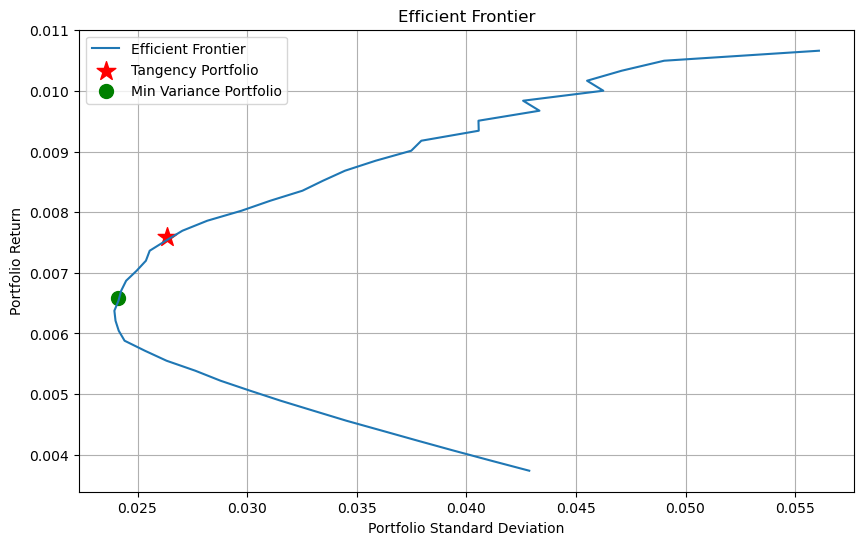

In [102]:

def efficient_frontier(mean_returns, cov_matrix, risk_free_rate, active_assets, passive_assets, num_points=50):


    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num_points)
    portfolio_returns = []
    portfolio_std_devs = []

    num_assets = len(mean_returns)

    bounds, constraints = constraint_functions(active_assets, passive_assets)


    def return_target_constraint(weights, target_return, mean_returns):
        return np.sum(mean_returns * weights) - target_return


    for target_return in target_returns:


        constraints_with_target = list(constraints)
        constraints_with_target.append({'type': 'eq', 'fun': lambda weights: return_target_constraint(weights, target_return, mean_returns)})


        initial_weights = np.array([1/num_assets] * num_assets)

        result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints_with_target)

        if result.success:
            weights = result.x
            portfolio_returns.append(np.sum(mean_returns * weights))
            portfolio_std_devs.append(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
        else:
            print(f"Efficient Frontier Optimization Failed for target return {target_return}:", result.message)
            portfolio_returns.append(np.nan)
            portfolio_std_devs.append(np.nan)

    return portfolio_returns, portfolio_std_devs



portfolio_returns, portfolio_std_devs = efficient_frontier(mean_returns, cov_matrix, risk_free_rate, active_assets, passive_assets)


try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_std_devs, portfolio_returns, label='Efficient Frontier')
    if tangency_weights is not None:
        tangency_return = np.sum(mean_returns * tangency_weights)
        tangency_std = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))
        plt.scatter(tangency_std, tangency_return, marker='*', s=200, color='r', label='Tangency Portfolio')

    if min_variance_weights is not None:
        min_var_return = np.sum(mean_returns * min_variance_weights)
        min_var_std = np.sqrt(np.dot(min_variance_weights.T, np.dot(cov_matrix, min_variance_weights)))
        plt.scatter(min_var_std, min_var_return, marker='o', s=100, color='g', label='Min Variance Portfolio')


    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier')
    plt.legend()
    plt.grid(True)
    plt.show()

except ImportError:
    print("matplotlib not found.  Skipping plotting.")

### b)

C:\Users\MSI\AppData\Local\Temp\ipykernel_13488\1945753700.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(asset, (annualized_std_devs[i], annualized_mean_returns[i]))


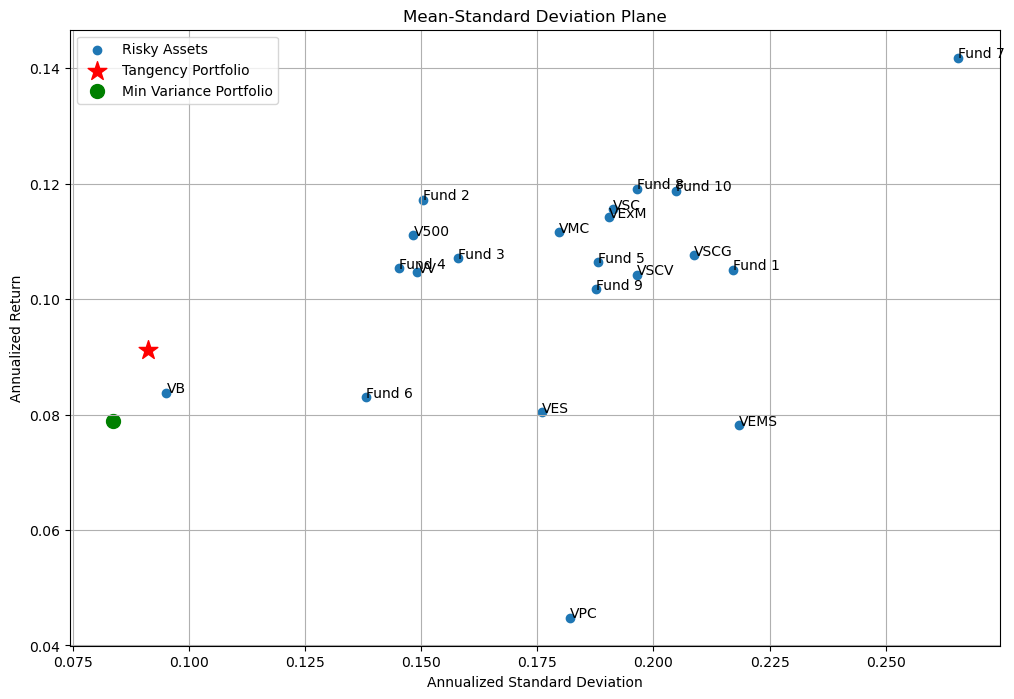

In [104]:
annualized_mean_returns = mean_returns * 12
annualized_std_devs = returns.std() * np.sqrt(12)

# Annualized tangency portfolio return and standard deviation
if tangency_weights is not None:
    tangency_return = np.sum(mean_returns * tangency_weights) * 12
    tangency_std = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights))) * np.sqrt(12)

# Annualized minimum variance portfolio return and standard deviation
if min_variance_weights is not None:
    min_var_return = np.sum(mean_returns * min_variance_weights) * 12
    min_var_std = np.sqrt(np.dot(min_variance_weights.T, np.dot(cov_matrix, min_variance_weights))) * np.sqrt(12)



plt.figure(figsize=(12, 8))

# Risky assets
plt.scatter(annualized_std_devs, annualized_mean_returns, marker='o', label='Risky Assets')

# Annotate the risky assets on the plot
for i, asset in enumerate(returns.columns):
    plt.annotate(asset, (annualized_std_devs[i], annualized_mean_returns[i]))

# Tangency portfolio
if tangency_weights is not None:
    plt.scatter(tangency_std, tangency_return, marker='*', s=200, color='r', label='Tangency Portfolio')

# Minimum variance portfolio
if min_variance_weights is not None:
    plt.scatter(min_var_std, min_var_return, marker='o', s=100, color='g', label='Min Variance Portfolio')

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Return')
plt.title('Mean-Standard Deviation Plane')
plt.legend()
plt.grid(True)
plt.show()

##Question 3

###a)

C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
C:\Users\MSI\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


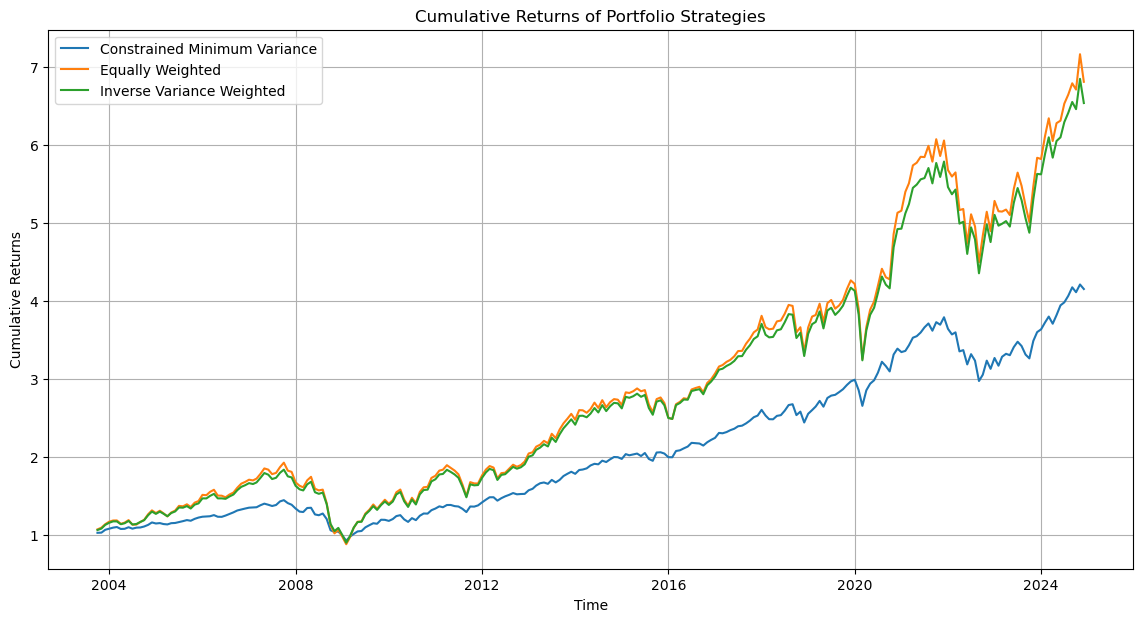

In [107]:
# Function to perform backtest on portfolio strategy given a weighting scheme
def backtest_ws(r, weighting, estimation_window=60, **kwargs):
    n_periods = r.shape[0]
    windows = [(start, start + estimation_window) for start in range(n_periods - estimation_window + 1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]


    weights = weights[:-1]

    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns", min_count=1)
    return returns, weights


# 1. Minimum Variance Portfolio Weighting Function
def min_var_weights(r, active_assets, passive_assets, **kwargs):
    cov_matrix = r.cov()
    num_assets = len(r.columns)
    initial_weights = np.array([1 / num_assets] * num_assets)

    def constraint_functions(active_assets, passive_assets):
        num_active = len(active_assets)
        num_passive = len(passive_assets)

        active_bounds = [(0, 0.1)] * num_active
        passive_bounds = [(-0.05, 1)] * num_passive
        bounds = active_bounds + passive_bounds

        def passive_constraint(weights):
            return np.sum(weights[num_active:]) - 0.5

        def active_constraint(weights):
            return np.sum(weights[:num_active]) - 0.25

        def sum_weights_constraint(weights):
            return np.sum(weights) - 1

        constraints = (
            {'type': 'eq', 'fun': sum_weights_constraint},
            {'type': 'ineq', 'fun': passive_constraint},
            {'type': 'ineq', 'fun': active_constraint}
        )
        return bounds, constraints

    active_assets = [col for col in r.columns if col in active_net_ret.columns]
    passive_assets = [col for col in r.columns if col in vanret.columns]

    bounds, constraints = constraint_functions(active_assets, passive_assets)

    def portfolio_variance(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:

        return np.array([np.nan] * num_assets)


# 2. Equally Weighted Portfolio Weighting Function
def equal_weights(r, **kwargs):
    n_assets = len(r.columns)
    return np.array([1 / n_assets] * n_assets)


# 3. Inverse Variance Weighted Portfolio Weighting Function
def inverse_variance_weights(r, **kwargs):
    variances = r.var()
    inv_variances = 1 / variances
    weights = inv_variances / inv_variances.sum()
    return weights.values


# Backtest the strategies
estimation_window = 60

# Active and passive assets
active_assets = [col for col in all_funds.columns if col in active_net_ret.columns]
passive_assets = [col for col in all_funds.columns if col in vanret.columns]

min_var_ret, min_var_weights_df = backtest_ws(all_funds, min_var_weights, estimation_window=estimation_window,
                                              active_assets=active_assets, passive_assets=passive_assets)
equal_wt_ret, equal_wt_weights_df = backtest_ws(all_funds, equal_weights, estimation_window=estimation_window)
inv_var_ret, inv_var_weights_df = backtest_ws(all_funds, inverse_variance_weights, estimation_window=estimation_window)

# Convert returns to cumulative returns
cumulative_min_var = (1 + min_var_ret).cumprod()
cumulative_equal_wt = (1 + equal_wt_ret).cumprod()
cumulative_inv_var = (1 + inv_var_ret).cumprod()


plt.figure(figsize=(14, 7))
plt.plot(cumulative_min_var, label="Constrained Minimum Variance")
plt.plot(cumulative_equal_wt, label="Equally Weighted")
plt.plot(cumulative_inv_var, label="Inverse Variance Weighted")
plt.title("Cumulative Returns of Portfolio Strategies")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


###b)

In [109]:
# Function to compute performance metrics
def portfolio_performance(returns, risk_free_rate=0.0):
    """Compute key performance metrics for a given returns series."""
    annualized_return = (1 + returns.mean())**12 - 1  # Annualized return
    annualized_std = returns.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std  # Sharpe Ratio

    # Downside risk: Sortino ratio
    downside_returns = returns[returns < 0]
    sortino_ratio = (annualized_return - risk_free_rate) / (downside_returns.std() * np.sqrt(12))

    # Max drawdown calculation
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    return annualized_return, annualized_std, sharpe_ratio, sortino_ratio, max_drawdown

# Performance for each strategy
min_var_metrics = portfolio_performance(min_var_ret)
equal_wt_metrics = portfolio_performance(equal_wt_ret)
inv_var_metrics = portfolio_performance(inv_var_ret)


performance_df = pd.DataFrame(
    [min_var_metrics, equal_wt_metrics, inv_var_metrics],
    index=["Minimum Variance", "Equal Weight", "Inverse Variance"],
    columns=["Annualized Return", "Annualized Std Dev", "Sharpe Ratio", "Sortino Ratio", "Max Drawdown"]
)


print(performance_df)


                  Annualized Return  Annualized Std Dev  Sharpe Ratio  \
Minimum Variance           0.073688            0.090396      0.815164   
Equal Weight               0.108998            0.161933      0.673104   
Inverse Variance           0.104737            0.149750      0.699411   

                  Sortino Ratio  Max Drawdown  
Minimum Variance       0.993014     -0.359976  
Equal Weight           0.868194     -0.543018  
Inverse Variance       0.906534     -0.509975  


The results highlight the trade-off between risk and return across the three portfolio strategies. The Equal Weight portfolio had the highest annualized return at 10.90%, followed closely by the Inverse Variance portfolio at 10.47%. As expected, the Minimum Variance portfolio delivered the lowest return at 7.37% since its goal is to minimize risk rather than maximize returns. This shows that while risk-focused strategies may sacrifice some return potential, they offer more stability over time.

When it comes to risk, the Minimum Variance portfolio successfully lowered volatility, with an annualized standard deviation of 9.04%—significantly lower than the Equal Weight (16.19%) and Inverse Variance (14.98%) portfolios. This lower volatility contributed to its superior Sharpe Ratio (0.815), meaning it delivered the best risk-adjusted return. The Equal Weight and Inverse Variance portfolios had lower Sharpe Ratios (0.673 and 0.699, respectively), indicating that while they generated higher returns, they also carried more risk.

Looking at downside risk, the Minimum Variance portfolio again performed the best, with the highest Sortino Ratio (0.993), reinforcing its ability to limit losses in downturns. The Inverse Variance (0.907) and Equal Weight (0.868) portfolios were more vulnerable to market declines, as seen in their Maximum Drawdowns. The Minimum Variance portfolio had the smallest peak-to-trough loss (-35.99%), while the Equal Weight (-54.30%) and Inverse Variance (-50.99%) portfolios experienced much steeper declines. This suggests that while higher-return strategies can be appealing, they come with deeper losses in bear markets.

Overall, the Minimum Variance portfolio is the best choice for risk-averse investors seeking stability and strong risk-adjusted returns. The Inverse Variance portfolio offers a middle ground, balancing return potential with some risk control. Meanwhile, the Equal Weight portfolio provides the highest returns but also comes with higher volatility and deeper drawdowns. Ultimately, the right choice depends on an investor’s risk tolerance and investment goals.

##Question 4

###a)

The fund manager’s reasoning is flawed because it focuses solely on the Vanguard Balanced Index Fund’s expected return, ignoring the principles of portfolio theory. While the fund's expected return is below 8% per annum, excluding it outright overlooks its potential diversification benefits, which could reduce overall portfolio risk, especially if it has low or negative correlations with other assets.

A more effective approach is to use mean-variance optimization (Markowitz portfolio theory), which seeks to maximize risk-adjusted return. The optimal portfolio consists of assets that, when combined, lie on the efficient frontier, offering the highest return for a given level of risk. Even if an asset’s expected return is below the threshold, it may still enhance the portfolio’s efficiency by lowering risk or improving overall return per unit of risk.

By rejecting investments based on an arbitrary return cutoff, the fund manager risks missing opportunities to build a more efficient portfolio. Instead of focusing on individual asset returns, the goal should be to optimize the entire portfolio’s performance, balancing return and risk effectively.

###b)

In [115]:
 #Constraints
def constraint_functions(active_assets, passive_assets):
    num_active = len(active_assets)
    num_passive = len(passive_assets)

    # Constraint 1: No short sales for active funds, max 10%
    active_bounds = [(0, 0.1)] * num_active

    # Constraint 2: Short sales restricted to 5% for passive funds, max 100%
    passive_bounds = [(-0.05, 1)] * num_passive

    # Combine bounds for all assets
    bounds = active_bounds + passive_bounds

    # Constraint 3: Total weight in passive indices >= 50%
    def passive_constraint(weights):
        return np.sum(weights[num_active:]) - 0.5  # >= 0

    # Constraint 4: Combined weight in active indices >= 25%
    def active_constraint(weights):
        return np.sum(weights[:num_active]) - 0.25  # >=0

    # Constraint 5: Sum of all weights must equal 1
    def sum_weights_constraint(weights):
        return np.sum(weights) - 1  # == 0

    # Constraints dictionary
    constraints = (
        {'type': 'eq', 'fun': sum_weights_constraint},  # Sum of weights = 1
        {'type': 'ineq', 'fun': passive_constraint},  # Passive >= 50%
        {'type': 'ineq', 'fun': active_constraint}  # Active >= 25%
    )

    return bounds, constraints


def optimize_tangency_portfolio(mean_returns, cov_matrix, risk_free_rate, active_assets, passive_assets):
    num_assets = len(mean_returns)
    initial_weights = np.array([1 / num_assets] * num_assets)  # Initial guess

    bounds, constraints = constraint_functions(active_assets, passive_assets)

    # Optimization
    result = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print("Tangency Portfolio Optimization Failed:", result.message)
        return None

# Filter assets based on the 8% return threshold
assets_to_include = mean_returns[mean_returns >= 0.08 / 12].index.tolist()  #monthly return
mean_returns_restricted = mean_returns[assets_to_include]
cov_matrix_restricted = cov_matrix.loc[assets_to_include, assets_to_include]

# Identify active and passive assets in the restricted universe
active_assets_restricted = [asset for asset in assets_to_include if asset in active_assets]
passive_assets_restricted = [asset for asset in assets_to_include if asset in passive_assets]

# Optimize the tangency portfolio with the restricted universe
tangency_weights_restricted = optimize_tangency_portfolio(
    mean_returns_restricted, cov_matrix_restricted, risk_free_rate, active_assets_restricted, passive_assets_restricted
)

#  Sharpe ratio of the restricted tangency portfolio
if tangency_weights_restricted is not None:
    tangency_return_restricted = np.sum(mean_returns_restricted * tangency_weights_restricted)
    tangency_std_restricted = np.sqrt(
        np.dot(tangency_weights_restricted.T, np.dot(cov_matrix_restricted, tangency_weights_restricted)))
    sharpe_ratio_restricted = (tangency_return_restricted - risk_free_rate) / tangency_std_restricted
    print(f"Sharpe Ratio (Restricted): {sharpe_ratio_restricted:.4f}")

    print("\nComposition of Tangency Portfolio (Restricted):")
    for i, asset in enumerate(assets_to_include):
        print(f"{asset}: {tangency_weights_restricted[i]:.4f}")

else:
    print("Could not calculate restricted tangency portfolio.")

# Compare to the original tangency portfolio
tangency_weights_original = optimize_tangency_portfolio(mean_returns, cov_matrix, risk_free_rate, active_assets,
                                                        passive_assets)
if tangency_weights_original is not None:
    tangency_return_original = np.sum(mean_returns * tangency_weights_original)
    tangency_std_original = np.sqrt(
        np.dot(tangency_weights_original.T, np.dot(cov_matrix, tangency_weights_original)))
    sharpe_ratio_original = (tangency_return_original - risk_free_rate) / tangency_std_original
    print(f"Sharpe Ratio (Original): {sharpe_ratio_original:.4f}")

    # Calculate Sharpe ratio loss
    sharpe_ratio_loss = sharpe_ratio_original - sharpe_ratio_restricted
    print(f"Sharpe Ratio Loss: {sharpe_ratio_loss:.4f}")

    print("\nComposition of Tangency Portfolio (Original):")
    for i, asset in enumerate(returns.columns):
        print(f"{asset}: {tangency_weights_original[i]:.4f}")



else:
    print("Could not calculate original Sharpe ratio")

Sharpe Ratio (Restricted): 0.1935

Composition of Tangency Portfolio (Restricted):
Fund 1: 0.0000
Fund 2: 0.1000
Fund 3: 0.0000
Fund 4: 0.1000
Fund 5: 0.0000
Fund 6: 0.0000
Fund 7: 0.0000
Fund 8: 0.0463
Fund 9: 0.0000
Fund 10: 0.0037
V500: 0.0753
VExM: -0.0500
VSC: -0.0253
VES: -0.0500
VV: -0.0500
VB: 1.0000
VMC: -0.0500
VSCG: -0.0500
VSCV: -0.0500
Sharpe Ratio (Original): 0.2050
Sharpe Ratio Loss: 0.0115

Composition of Tangency Portfolio (Original):
Fund 1: 0.0000
Fund 2: 0.1000
Fund 3: 0.0000
Fund 4: 0.1000
Fund 5: 0.0000
Fund 6: 0.0000
Fund 7: 0.0000
Fund 8: 0.0288
Fund 9: 0.0000
Fund 10: 0.0212
V500: 0.1216
VExM: -0.0500
VSC: -0.0031
VES: -0.0500
VPC: -0.0500
VV: -0.0184
VB: 1.0000
VEMS: -0.0500
VMC: -0.0500
VSCG: -0.0500
VSCV: -0.0500


The Sharpe ratio loss from restricting the investment universe is 0.00115

###c)

In [118]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def target_return_portfolio(mean_returns, cov_matrix, risk_free_rate, target_return, active_assets, passive_assets):
    num_assets = len(mean_returns)
    initial_weights = np.array([1 / num_assets] * num_assets)
    bounds, constraints = constraint_functions(active_assets, passive_assets)

    # Constraint: Expected portfolio return = target return
    def return_constraint(weights):
        return np.sum(weights * mean_returns) - target_return  # == 0

    constraints += ({'type': 'eq', 'fun': return_constraint},)

    result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print("Target Return Portfolio Optimization Failed:", result.message)
        return None

# Define mutual funds as all assets that are not in passive_assets
mutual_funds = [fund for fund in mean_returns.index if fund not in passive_assets]

# Remove specified assets from the portfolio
excluded_assets = {'V500', 'VExM', 'VSC', 'VES', 'VV', 'VB', 'VMC', 'VSCG', 'VSCV'}
assets_to_include = [fund for fund in mutual_funds if fund not in excluded_assets]


print("\nMutual Funds Identified:", mutual_funds)
print("\nAssets Included in Portfolio:", assets_to_include)

# CPortfolio for target return of 10%
target_return = 0.10 / 12  # Monthly return assumption
target_weights = target_return_portfolio(mean_returns, cov_matrix, risk_free_rate, target_return, active_assets, passive_assets)

# Positions in excluded mutual funds (filtering only mutual funds)
excluded_mutual_funds = [asset for asset in mean_returns.index if asset not in assets_to_include and asset in mutual_funds]


print("\nExcluded Mutual Funds:", excluded_mutual_funds)

positions_in_excluded = {fund: target_weights[mean_returns.index.get_loc(fund)] for fund in excluded_mutual_funds}

print("\nPositions in Excluded Mutual Funds:")
for fund, weight in positions_in_excluded.items():
    print(f"{fund}: {weight:.4f}")






Mutual Funds Identified: ['Fund 1', 'Fund 2', 'Fund 3', 'Fund 4', 'Fund 5', 'Fund 6', 'Fund 7', 'Fund 8', 'Fund 9', 'Fund 10']

Assets Included in Portfolio: ['Fund 1', 'Fund 2', 'Fund 3', 'Fund 4', 'Fund 5', 'Fund 6', 'Fund 7', 'Fund 8', 'Fund 9', 'Fund 10']

Excluded Mutual Funds: []

Positions in Excluded Mutual Funds:


# Exercise 3

## Setup

In [121]:
# Load the data
data = pd.read_excel("assignment_data_2025.xlsx", sheet_name = "buffetts_alpha_data", header=0, index_col=0)
# Set date index to montly
data.index = pd.to_datetime(data.index, format="%Y%m%d").to_period('D')

In [122]:
# Rename the columns
data = data.rename(columns={'Berkshire Hathaway, total return': 'r_brk',
                                 'Public stocks from 13F, total return': 'r_brkp',
                                 'Heinz, total return': 'r_hnz',
                                 'Lubrizol, total return': 'r_lz',
                                 'MKT (excess return)': 'MKT'})
data.columns

Index(['r_brk', 'r_brkp', 'r_lz', 'r_hnz', 'rf', 'MKT', 'SMB', 'HML', 'QMJ',
       'BAB', 'UMD'],
      dtype='object')

In [123]:
#Assuming regressions for the full timespan available for each security

heinz_rets = data.drop(columns=[ 'r_brk', 'r_brkp' ,'MKT' ]).dropna()
lubrizol_rets = data.drop(columns=[ 'r_brk', 'r_brkp' ,'MKT' ]).dropna()

heinz_rets['excess_ret_hnz'] = data['r_hnz']-data['rf']
lubrizol_rets['excess_ret_lz'] = data['r_lz']-data['rf']

## Question 1

### a)

In [126]:
# Create a new column for Berkshire Hathaway's excess returns
data['excess_brk'] = data['r_brk'] - data['rf']

# The regression equation is: excess_brk = alpha + beta * MKT + error
BHat, StdB, tstat, pval, lm = reg('excess_brk ~ MKT', data)

# Extract the estimated monthly alpha (intercept) and beta (slope)
alpha_monthly = BHat[0]
beta = BHat[1]

# Annualize the monthly alpha by multiplying by 12
alpha_annualized = alpha_monthly * 12

# Display the results
print("Monthly CAPM alpha:", alpha_monthly)
print("Annualized CAPM alpha:", alpha_annualized)
print("CAPM beta:", beta)

Monthly CAPM alpha: 0.011179506598327338
Annualized CAPM alpha: 0.13415407917992805
CAPM beta: 0.6883941010250243




### CAPM Model Interpretation
- **Monthly Alpha:** 0.0112 → **Annualized Alpha:** 0.1342
- **Beta (MKT):** 0.6884

**Key Insights:**
- **Alpha Interpretation:** The alpha (0.1342 annualized) represents the abnormal return Berkshire Hathaway achieved that is not explained by market movements alone. Since this value is positive and relatively large, it suggests that Berkshire Hathaway has historically outperformed the market on a risk-adjusted basis.
- **Beta Interpretation:** The beta (0.688) indicates that Berkshire Hathaway’s returns are **less volatile than the market**. A beta below 1 suggests that Berkshire Hathaway’s returns move less aggressively than the market. For example, if the market increases by 1%, Berkshire Hathaway’s expected return would increase by only **0.688%**.

**Conclusion:** The CAPM model suggests that Berkshire Hathaway has delivered **significant excess returns** (alpha) while maintaining **below-market volatility** (beta < 1).




### b)

In [129]:
# Run the Fama-French 3-factor regression
BHat_ff3, StdB_ff3, tstat_ff3, pval_ff3, lm_ff3 = reg('excess_brk ~ MKT + SMB + HML', data)

# Extract the estimated coefficients:
alpha_ff3_monthly = BHat_ff3[0]
beta_MKT = BHat_ff3[1]
beta_SMB = BHat_ff3[2]
beta_HML = BHat_ff3[3]

# Annualize the monthly alpha by multiplying by 12
alpha_ff3_annualized = alpha_ff3_monthly * 12

# Display the results
print("Fama-French 3-factor model results:")
print("Monthly alpha:", alpha_ff3_monthly)
print("Annualized alpha:", alpha_ff3_annualized)
print("Beta (MKT):", beta_MKT)
print("Beta (SMB):", beta_SMB)
print("Beta (HML):", beta_HML)


Fama-French 3-factor model results:
Monthly alpha: 0.009670950784982625
Annualized alpha: 0.1160514094197915
Beta (MKT): 0.8181949451096554
Beta (SMB): -0.28520988189753926
Beta (HML): 0.4507335554825512


### Fama-French 3-Factor Model Interpretation
- **Monthly Alpha:** 0.0097 → **Annualized Alpha:** 0.1161
- **Beta (MKT):** 0.8182
- **Beta (SMB):** -0.2852
- **Beta (HML):** 0.4507

**Key Insights:**
- **Alpha Interpretation:** The alpha (0.1161 annualized) is still positive but **lower than the CAPM alpha**, indicating that Berkshire Hathaway’s excess return is partially explained by additional factors beyond just the market. However, there is still a component of performance that cannot be explained by standard factors, hinting at Buffett's investment skill or unique strategy.
- **Beta (MKT) Interpretation:** The beta (0.8182) is closer to 1 compared to the CAPM model, indicating that Berkshire Hathaway's returns are now seen as **more correlated with the overall market**.
- **Beta (SMB) Interpretation:** The negative SMB beta (-0.2852) suggests that Berkshire Hathaway tends to invest more in **large-cap stocks** rather than small-cap stocks.
- **Beta (HML) Interpretation:** The positive HML beta (0.4507) suggests that Berkshire Hathaway is **tilted toward value stocks**, aligning with Buffett’s well-known value investing philosophy.

**Conclusion:** The FF3 model indicates that Berkshire Hathaway's success is partially linked to its **value stock focus** and **large-cap preference**, but still shows evidence of Buffett's ability to generate positive alpha.

### c)

In [132]:
# Run the 5-factor regression
BHat_ff5, StdB_ff5, tstat_ff5, pval_ff5, lm_ff5 = reg('excess_brk ~ MKT + SMB + HML + BAB + QMJ', data)

# Extract the estimated coefficients:
alpha_ff5_monthly = BHat_ff5[0]
beta_MKT_ff5 = BHat_ff5[1]
beta_SMB_ff5 = BHat_ff5[2]
beta_HML_ff5 = BHat_ff5[3]
beta_BAB_ff5 = BHat_ff5[4]
beta_QMJ_ff5 = BHat_ff5[5]

# Annualize the monthly alpha by multiplying by 12
alpha_ff5_annualized = alpha_ff5_monthly * 12

# Display the results
print("5-Factor Model Results:")
print("Monthly alpha:", alpha_ff5_monthly)
print("Annualized alpha:", alpha_ff5_annualized)
print("Beta (MKT):", beta_MKT_ff5)
print("Beta (SMB):", beta_SMB_ff5)
print("Beta (HML):", beta_HML_ff5)
print("Beta (BAB):", beta_BAB_ff5)
print("Beta (QMJ):", beta_QMJ_ff5)

5-Factor Model Results:
Monthly alpha: 0.004332323480962094
Annualized alpha: 0.051987881771545126
Beta (MKT): 0.9567283091963219
Beta (SMB): -0.13742962128702615
Beta (HML): 0.4224686880671342
Beta (BAB): 0.24878667933549448
Beta (QMJ): 0.443704585661821


### Fama-French 5-Factor Model Interpretation
- **Monthly Alpha:** 0.0043 → **Annualized Alpha:** 0.0520
- **Beta (MKT):** 0.9567
- **Beta (SMB):** -0.1374
- **Beta (HML):** 0.4225
- **Beta (BAB):** 0.2488
- **Beta (QMJ):** 0.4437

**Key Insights:**
- **Alpha Interpretation:** The alpha is now reduced to **0.0520** (annualized), substantially lower than in the CAPM and FF3 models. This indicates that much of Berkshire Hathaway’s abnormal returns are now better explained by exposure to multiple risk factors. However, the positive alpha still suggests Buffett's strategy provides additional value beyond these known risk factors.
- **Beta (MKT) Interpretation:** The beta has increased to **0.9567**, meaning Berkshire Hathaway’s returns are now seen as **more aligned with the overall market** than before.
- **Beta (SMB) Interpretation:** The negative SMB beta (-0.1374) remains consistent with Berkshire Hathaway’s **large-cap bias**.
- **Beta (HML) Interpretation:** The positive HML beta (0.4225) reinforces Berkshire’s **value investing tilt**.
- **Beta (BAB) Interpretation:** The positive BAB beta (0.2488) indicates that Berkshire Hathaway tends to favor **low-beta (defensive)** stocks, which aligns with Buffett’s well-known preference for stable, fundamentally strong businesses.
- **Beta (QMJ) Interpretation:** The positive QMJ beta (0.4437) suggests Berkshire invests in **high-quality stocks**, characterized by profitable, stable, and well-managed firms.

## Question 2

In [135]:
# Create a new column for the excess returns of the public stocks portfolio
data['excess_brkp'] = data['r_brkp'] - data['rf']

# CAPM regression for the 13F portfolio
BHat_brkp_capm, StdB_brkp_capm, tstat_brkp_capm, pval_brkp_capm, lm_brkp_capm = reg('excess_brkp ~ MKT', data)
alpha_brkp_capm = BHat_brkp_capm[0]
beta_brkp_capm = BHat_brkp_capm[1]
alpha_brkp_capm_annualized = alpha_brkp_capm * 12

# Create a summary table for the CAPM model
results_capm = {
    "Metric": ["Monthly Alpha", "Annualized Alpha", "Beta (MKT)"],
    "Value": [alpha_brkp_capm, alpha_brkp_capm_annualized, beta_brkp_capm]}
df_capm = pd.DataFrame(results_capm)



# Fama-French 3-factor regression for the public portfolio
BHat_brkp_ff3, StdB_brkp_ff3, tstat_brkp_ff3, pval_brkp_ff3, lm_brkp_ff3 = reg('excess_brkp ~ MKT + SMB + HML', data)
alpha_brkp_ff3 = BHat_brkp_ff3[0]
beta_MKT_brkp_ff3 = BHat_brkp_ff3[1]
beta_SMB_brkp_ff3 = BHat_brkp_ff3[2]
beta_HML_brkp_ff3 = BHat_brkp_ff3[3]
alpha_brkp_ff3_annualized = alpha_brkp_ff3 * 12

# Create a summary table for the Fama-French 3-factor model
results_ff3 = {
    "Metric": ["Monthly Alpha", "Annualized Alpha", "Beta (MKT)", "Beta (SMB)", "Beta (HML)"],
    "Value": [alpha_brkp_ff3, alpha_brkp_ff3_annualized, beta_MKT_brkp_ff3, beta_SMB_brkp_ff3, beta_HML_brkp_ff3]}
df_ff3 = pd.DataFrame(results_ff3)



# Fama-French 5-factor regression for the public portfolio
BHat_brkp_ff5, StdB_brkp_ff5, tstat_brkp_ff5, pval_brkp_ff5, lm_brkp_ff5 = reg('excess_brkp ~ MKT + SMB + HML + BAB + QMJ', data)
alpha_brkp_ff5 = BHat_brkp_ff5[0]
beta_MKT_brkp_ff5 = BHat_brkp_ff5[1]
beta_SMB_brkp_ff5 = BHat_brkp_ff5[2]
beta_HML_brkp_ff5 = BHat_brkp_ff5[3]
beta_BAB_brkp_ff5 = BHat_brkp_ff5[4]
beta_QMJ_brkp_ff5 = BHat_brkp_ff5[5]
alpha_brkp_ff5_annualized = alpha_brkp_ff5 * 12

# Create a summary table for the Fama-French 5-factor model
results_ff5 = {
    "Metric": ["Monthly Alpha", "Annualized Alpha", "Beta (MKT)", "Beta (SMB)", "Beta (HML)", "Beta (BAB)", "Beta (QMJ)"],
    "Value": [alpha_brkp_ff5, alpha_brkp_ff5_annualized, beta_MKT_brkp_ff5, beta_SMB_brkp_ff5, beta_HML_brkp_ff5, beta_BAB_brkp_ff5, beta_QMJ_brkp_ff5]}
df_ff5 = pd.DataFrame(results_ff5)



print("CAPM Model for Public Stocks Portfolio")
print(df_capm)
print("\nFama-French 3-Factor Model for Public Stocks Portfolio")
print(df_ff3)
print("\nFama-French 5-Factor Model for Public Stocks Portfolio")
print(df_ff5)

CAPM Model for Public Stocks Portfolio
             Metric     Value
0     Monthly Alpha  0.004801
1  Annualized Alpha  0.057613
2        Beta (MKT)  0.770764

Fama-French 3-Factor Model for Public Stocks Portfolio
             Metric     Value
0     Monthly Alpha  0.003617
1  Annualized Alpha  0.043400
2        Beta (MKT)  0.853642
3        Beta (SMB) -0.189668
4        Beta (HML)  0.288394

Fama-French 5-Factor Model for Public Stocks Portfolio
             Metric     Value
0     Monthly Alpha  0.000090
1  Annualized Alpha  0.001078
2        Beta (MKT)  0.960188
3        Beta (SMB) -0.072583
4        Beta (HML)  0.296839
5        Beta (BAB)  0.113608
6        Beta (QMJ)  0.324864


## Question 3

In [137]:
# Create excess return series for both
data['excess_brk'] = data['r_brk'] - data['rf']
data['excess_brkp'] = data['r_brkp'] - data['rf']

# Compute monthly averages and standard deviations
mean_brk = data['excess_brk'].mean()
mean_brkp = data['excess_brkp'].mean()

std_brk = data['excess_brk'].std()
std_brkp = data['excess_brkp'].std()

# Annualize the average excess returns and standard deviations
annual_excess_brk = mean_brk * 12
annual_excess_brkp = mean_brkp * 12

annual_vol_brk = std_brk * np.sqrt(12)
annual_vol_brkp = std_brkp * np.sqrt(12)

# Compute the Sharpe ratios
sharpe_brk = annual_excess_brk / annual_vol_brk
sharpe_brkp = annual_excess_brkp / annual_vol_brkp

# Create summary tables
results = {
    "Metric": ["Annualized Excess Return", "Annualized Volatility", "Sharpe Ratio"],
    "Berkshire Hathaway": [annual_excess_brk, annual_vol_brk, sharpe_brk],
    "Public Stocks Portfolio": [annual_excess_brkp, annual_vol_brkp, sharpe_brkp]}

df_results = pd.DataFrame(results)
print(df_results)


                     Metric  Berkshire Hathaway  Public Stocks Portfolio
0  Annualized Excess Return            0.186185                 0.120314
1     Annualized Volatility            0.235646                 0.162465
2              Sharpe Ratio            0.790102                 0.740553


* **Annualized Excess Return:**

Berkshire Hathaway (18.62%): The whole corporation achieved a larger excess return than its public stock portfolio.
Public stock portfolio (12.03%):  The returns on publicly listed investments are lower, implying that Berkshire's superior success may be due in large part to its non-public commercial activities.

* **Annualized Volatility:**

Berkshire Hathaway (23.56%): The firm's total results are more variable.
Public stock portfolio (16.25%):  The public portfolio has reduced volatility. This might be because public stocks are often more steady blue chips, but the total firm's performance comprises parts with greater unpredictability in returns.

* **Sharpe Ratio:**

Berkshire Hathaway (0.79): Despite the higher volatility, the overall firm delivers a slightly better risk-adjusted performance.
Public Stocks Portfolio (0.74): While still respectable, the public portfolio’s risk-adjusted performance is marginally lower.


*  **Possible Sources of Differences (Informed by Frazzini, Kabiller, and Pedersen, 2018)**

1. Leverage and Capital Structure:

Overall Berkshire:
    The corporation makes substantial use of leverage, particularly its insurance float, which offers access to low-cost financing. This leverage increases both return and volatility. Frazzini, Kabiller, and Pedersen (2018) show that accounting for leverage (approximately 1.7:1 for Berkshire) considerably increases excess returns relative to the market.

Public Stock Portfolio:
    The 13F portfolio simply shows Buffett's stock picking method. It excludes the impact of the firm's indebtedness and financial gains from its private businesses.

2. Factor Exposures and Stock Selection:

Public Stock Portfolio:
     Frazzini, Kabiller, and Pedersen (2018) found that when variables like betting against beta (BAB) and quality minus junk (QMJ) are taken into account, most of the "Buffett's alpha" in the public portfolio becomes statistically unimportant.  This shows that systematic exposures to low-beta, high-quality, and value stocks might account for a considerable portion of the anomalous returns.

Berkshire's overall return incorporates factors like operational choices and a "Buffett effect" that typical factor models may not completely capture.

3. Diversification and Operational Contributions in Berkshire:

Berkshire Hathaway's portfolio comprises a number of completely owned private enterprises, in addition to public stock interests.  These running firms have distinct risk-return profiles (typically with more steady or counter-cyclical cash flows) and can provide extra alpha not seen in the public portfolio.

The Public Stocks Portfolio focuses only on Buffett's public stock choices.  While it still represents his value and quality emphasis, it lacks the diversity and operational advantages that come with owning private enterprises.




## Question 4

In [140]:
heinz = {
    "price": 60.480, #in dollars
    "earnings": 923.159, #in millions
    "book_value":2810.822, #in millions
    "basic_shares_out": 320.686, #in millions
    "DPS": 1.92, #in dollars
}

lubrizol = {
    "price": 105.44, #in dollars
    "earnings": 1004.3, #in millions
    "book_value": 2271.1, #in millions
    "basic_shares_out": 67.3, #in millions
    "DPS": 1.39, #in dollars
}

### a + b + c + d )

In [142]:
# For Heinz:
heinz['EPS'] = heinz['earnings'] / heinz['basic_shares_out']
heinz['BookPerShare'] = heinz['book_value'] / heinz['basic_shares_out']
heinz['E/P (%)'] = (heinz['EPS'] / heinz['price']) * 100
heinz['B/M'] = heinz['BookPerShare'] / heinz['price']
heinz['D/P (%)'] = (heinz['DPS'] / heinz['price']) * 100
heinz['E/B (%)'] = (heinz['earnings'] / heinz['book_value']) * 100

# For Lubrizol:
lubrizol['EPS'] = lubrizol['earnings'] / lubrizol['basic_shares_out']
lubrizol['BookPerShare'] = lubrizol['book_value'] / lubrizol['basic_shares_out']
lubrizol['E/P (%)'] = (lubrizol['EPS'] / lubrizol['price']) * 100
lubrizol['B/M'] = lubrizol['BookPerShare'] / lubrizol['price']
lubrizol['D/P (%)'] = (lubrizol['DPS'] / lubrizol['price']) * 100
lubrizol['E/B (%)'] = (lubrizol['earnings'] / lubrizol['book_value']) * 100

# Combine the dictionaries into a DataFrame
ratios = {
    "Heinz": heinz,
    "Lubrizol": lubrizol}

# Display results
ratios_df = pd.DataFrame(ratios)
ratios_df.round(2)

,Heinz,Lubrizol
price,60.48,105.44
earnings,923.16,1004.30
book_value,2810.82,2271.10
basic_shares_out,320.69,67.30
DPS,1.92,1.39
EPS,2.88,14.92
BookPerShare,8.77,33.75
E/P (%),4.76,14.15
B/M,0.14,0.32
D/P (%),3.17,1.32


### e)

In [144]:
# Create a subset for Heinz; drop columns not needed
heinz_ret = data.drop(columns=[ 'r_brk', 'r_brkp']).dropna().copy()
heinz_ret['excess_ret_hnz'] = data['r_hnz']-data['rf']

# Run the CAPM regression: excess_ret_hnz ~ MKT
BHat_heinz, StdB_heinz, tstat_heinz, pval_heinz, lm_heinz = reg("excess_ret_hnz ~ MKT", data=heinz_ret)

alpha_heinz_monthly = BHat_heinz[0]
beta_heinz = BHat_heinz[1]
alpha_heinz_annual = alpha_heinz_monthly * 12  # Annualize alpha

print("Heinz CAPM regression results:")
print("Monthly Alpha:", alpha_heinz_monthly)
print("Annualized Alpha:", alpha_heinz_annual)
print("Beta:", beta_heinz)

Heinz CAPM regression results:
Monthly Alpha: 0.003486076338680654
Annualized Alpha: 0.04183291606416785
Beta: 0.3863349981515184


In [145]:
# Create a subset for Lubrizol; drop columns not needed
lubrizol_ret = data.drop(columns=['r_brk', 'r_brkp']).dropna().copy()
lubrizol_ret['excess_ret_lz'] = data['r_lz'] - data['rf']

# Run the CAPM regression: excess_ret_lz ~ MKT
BHat_lubrizol, StdB_lubrizol, tstat_lubrizol, pval_lubrizol, lm_lubrizol = reg("excess_ret_lz ~ MKT", data=lubrizol_ret)

alpha_lubrizol_monthly = BHat_lubrizol[0]
beta_lubrizol = BHat_lubrizol[1]
alpha_lubrizol_annual = alpha_lubrizol_monthly * 12  # Annualize alpha

print("Lubrizol CAPM regression results:")
print("Monthly Alpha:", alpha_lubrizol_monthly)
print("Annualized Alpha:", alpha_lubrizol_annual)
print("Beta:", beta_lubrizol)

Lubrizol CAPM regression results:
Monthly Alpha: 0.008899035091493566
Annualized Alpha: 0.10678842109792279
Beta: 0.9328680525565365


### f)

In [147]:
# For Heinz:
BHat_heinz_ff5, StdB_heinz_ff5, tstat_heinz_ff5, pval_heinz_ff5, lm_heinz_ff5 = reg(
    "excess_ret_hnz ~ MKT + SMB + HML + BAB + QMJ", data=heinz_ret
)
alpha_heinz_ff5 = BHat_heinz_ff5[0]
beta_heinz_ff5 = BHat_heinz_ff5[1:]   # Betas for MKT, SMB, HML, BAB, QMJ
alpha_heinz_ff5_annual = alpha_heinz_ff5 * 12  # Annualize monthly alpha

print("Heinz 5-Factor Regression Results:")
print("Monthly Alpha:", alpha_heinz_ff5)
print("Annualized Alpha:", alpha_heinz_ff5_annual)
print("Factor Betas (MKT, SMB, HML, BAB, QMJ):", beta_heinz_ff5)

Heinz 5-Factor Regression Results:
Monthly Alpha: -0.0005714002536607498
Annualized Alpha: -0.0068568030439289974
Factor Betas (MKT, SMB, HML, BAB, QMJ): [ 0.67687837 -0.07262233  0.23729641  0.22013062  0.34670757]


In [148]:
# For Lubrizol:
BHat_lubrizol_ff5, StdB_lubrizol_ff5, tstat_lubrizol_ff5, pval_lubrizol_ff5, lm_lubrizol_ff5 = reg(
    "excess_ret_lz ~ MKT + SMB + HML + BAB + QMJ", data=lubrizol_ret
)
alpha_lubrizol_ff5 = BHat_lubrizol_ff5[0]
beta_lubrizol_ff5 = BHat_lubrizol_ff5[1:]  # Betas for MKT, SMB, HML, BAB, QMJ
alpha_lubrizol_ff5_annual = alpha_lubrizol_ff5 * 12  # Annualize monthly alpha

print("\nLubrizol 5-Factor Regression Results:")
print("Monthly Alpha:", alpha_lubrizol_ff5)
print("Annualized Alpha:", alpha_lubrizol_ff5_annual)
print("Factor Betas (MKT, SMB, HML, BAB, QMJ):", beta_lubrizol_ff5)


Lubrizol 5-Factor Regression Results:
Monthly Alpha: 0.003007295069951609
Annualized Alpha: 0.036087540839419306
Factor Betas (MKT, SMB, HML, BAB, QMJ): [1.21197082 0.25684842 0.8851808  0.01468227 0.42423356]


### **Heinz**
A discretionary investor may have been interested in **Heinz** given its relatively stable yet modest performance characteristics.  

- **Earnings to Price (E/P): 4.76%** : Heinz's E/P ratio is somewhat higher than the NYSE median (3.7%), but lower than the **75th percentile (6.1%)**.  This shows that Heinz was relatively discounted in respect to the wider NYSE, which may have appealed to value investors seeking stable but conservative returns.

- **Dividend Yield (D/P): 3.17%**: Heinz's dividend yield is **well over the 75th percentile of NYSE companies (2.6%)**, making it an intriguing option for dividend investors.  This is consistent with the characteristics of "cash cow" equities, which are frequently old, stable corporations with substantial cash flows, particularly in the food and beverage industry.

- **Earnings To Book (E/B): 32.84%**: Heinz's E/B ratio is **much higher than the NYSE's 75th percentile (22.6%)**, indicating efficient asset usage and high profitability compared to book value.

In terms of risk-adjusted performance:

- **CAPM Alpha:** Heinz's **annualized CAPM alpha of 4.18%** suggests it delivered modest excess returns after adjusting for market risk, indicating some level of skill in generating superior returns.

- **5-Factor Alpha:** The **5-factor alpha of -0.69%** (negative) suggests that after accounting for additional risk factors like size, value, low-beta, and quality, Heinz’s performance was actually slightly below expectations. This indicates that Heinz’s outperformance in the CAPM model may have been better explained by these additional risk factors.

- **Beta:** Heinz's **CAPM beta of 0.39** indicates lower volatility than the broader market, meaning Heinz had defensive characteristics. Meanwhile, its **5-factor beta of 0.68 (MKT loading)** suggests moderate market exposure with tilts towards **value (HML: 0.24)** and **quality (QMJ: 0.35)** factors, reinforcing its stability and profitability profile.

---

### **Lubrizol**
A discretionary investor may have been attracted to **Lubrizol** due to its strong value profile and robust market exposure.

- **Earnings to Price (E/P): 14.15%** — Lubrizol's E/P ratio is **well above the 75th percentile** of NYSE stocks (6.1%), indicating that it was significantly undervalued, which is highly attractive to value investors.

- **Dividend Yield (D/P): 1.32%** — Lubrizol’s D/P ratio is modestly above the NYSE median (1.1%) but below the 75th percentile (2.6%). While not a standout feature, this stable dividend yield still aligns with income-generating potential.

- **Earnings to Book (E/B): 44.22%** — Lubrizol’s E/B ratio is **substantially above the 75th percentile** of NYSE stocks (22.6%), highlighting its strong profitability relative to its book value and efficient asset utilization.

In terms of risk-adjusted performance:

- **CAPM Alpha:** Lubrizol's **annualized CAPM alpha of 10.68%** is significantly higher than Heinz’s, indicating impressive excess returns relative to market risk.

- **5-Factor Alpha:** Lubrizol’s **5-factor alpha of 3.61%** remains positive, suggesting that even after adjusting for risk factors such as size, value, low-beta, and quality, Lubrizol continued to deliver superior performance.

- **Beta:** Lubrizol’s **CAPM beta of 0.93** indicates that its volatility closely mirrors the broader market. Its **5-factor beta of 1.21 (MKT loading)** shows stronger market sensitivity and indicates higher exposure to systematic risk. Additionally, Lubrizol had a strong tilt towards **value (HML: 0.89)** and **quality (QMJ: 0.42)** factors, both of which support its robust returns.
